###### 2020-10-06 화요일

# IMDB 엔드게임 영화평점 크롤링 + 감정분석 + 워드클라우드 (실습)
##### 이 정리 내용은 멀티캠퍼스 4차산업혁명 선도인력양성과정 내용을 정리한 것입니다.

> - IMDB는 아마존닷컴의 자회사이며 서양의 영화정보 모음 사이트입니다.


#### -목차
> ##### 1. IMDB - 엔드게임 크롤링 + 감정분석
> ##### 2. WordCloud
> ##### 3. IMDb의 엔드게임 크롤링 데이터 WordCloud해보기

## 진행전에 세팅부터 하시죠

##### 파이썬에서 자연어처리를 실행하게 도와주는 패키지를 설치합시다

1. 아나콘다 프롬프트를 권리자 권한으로 실행하고 `conda install konlpy` 또는 `pip install konlpy`입력합니다. (걍 둘다 설치하세요)
2. 설치가 완료되면 python을 입력해 터미널을 바꾸고 `import nltk`를 입력하세요 
   (`nltk`는 `konlpy`와 같이 파이썬에서 자연어 처리를 도와주는 패키지입니다.)
3. 그러면 어떤 창이하나 뜨는데 `stopwords`와 `punkt`를 설치하고 빠져나오세요.
   (불용어 처리를 위해 설치하는 거에요)
4. 아나콘다 프롬프트에서 ctrl + z를 눌러 파이썬 터미널을 빠져나온다

##### 워드클라우드를 도와주는 패키지도 함께 설치합시다

1. 아나콘다 프롬프트를 권리자 권한으로 실행하고 `coanda install wordcloud`를 입력하세요.
2. `conda install gensim`도 입력하세요. 단어를 벡터로 만들어주는 패키지라 생각하면돼요.
    혹시 에러나면 `conda install -c conda-forge gensim`으로 해보세요 (아마 파이썬 3.8버전에서는 이걸로 해야 설치가 될거에요)
3. `conda install -c conda-forge jpype1`를 입력하세요 
   (자바와 파이썬을 통신하게 만들어주는 패키지에요)



이제 자연어처리 해볼까요~

## 1. IMDB - 엔드게임 크롤링 + 감정분석

### (1) 라이브러리와 url 세팅!

In [23]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
from urllib.error import HTTPError
from urllib.error import URLError

In [24]:
url = "https://www.imdb.com/title/tt4154756/reviews?ref_=tt_ql_3"

try:
    html = urlopen(url)
except HTTPError as he:
    print("http error")
except URLError as ue:
    print("rul error")
else :
    soup = BeautifulSoup(html.read(), "html.parser", from_encoding='UTF-8')

### (2) 크롤링과 파싱을 이용해 데이터를 가져옵니다!
 - 이제 이정도는 쉽게 할 줄 알아야 해요!!

In [61]:
# 가져와야할 것들 : 점수(별점), 리뷰제목, 작성자 닉네임, 작성날짜, 리뷰내용

# 점수
raw_rating = soup.findAll("span", {"class" : "rating-other-user-rating"})
rating = [element.find("span").text + element.find("span", {"class" : "point-scale"}).text for element in raw_rating]
print(rating)

# 리뷰 제목
title = soup.findAll("a", {"class" : "title"})
review_title = [element.text.strip() for element in title]
print(review_title)

# 작성자 닉네임
name = soup.findAll("span", {"class" : "display-name-link"})
user_name = [element.text for element in name]
print(user_name)

# 작성 날짜
date = soup.findAll("span", {"class" : "review-date"})
write_date = [element.text for element in date]
print(write_date)

# 리뷰 내용
review = soup.findAll("div", {"class" : "text show-more__control"})
write_review = [element.text for element in review]
print(write_review)


print(len(rating))
print(len(user_name))
print(len(review_title))
print(len(write_date))
print(len(write_review))

['9/10', '10/10', '10/10', '10/10', '10/10', '10/10', '10/10', '10/10', '10/10', '9/10', '9/10', '9/10', '10/10', '10/10', '9/10', '10/10', '10/10', '10/10', '10/10', '10/10', '10/10', '9/10', '10/10', '10/10', '8/10']
['Great', 'Way better than endgame', "IT'S NOT A MASTERPIECE..", 'Somehow they pulled this off', 'Unlike anything ever done in the history of cinema', 'This movie will blow your mind and break your heart - and make you desperate to go back for more. Brave, brilliant and better than it has any right to be.', 'Best movie Avengers infinity war 2018', 'Worth the wait, believe the hype', 'A Summer Film That IS Even Better Than The Hype', 'Excellent Film', 'Breathtaking', 'the final battle in this movie was great and very enjoyable and it is only topped by its sequel which offered a truly EPIC battle of APOCALYPTIC proportions', "The amount of people that don't understand the movie is astonishing", 'Adventure Awaits', 'Great movie', 'The best marvel film!', 'Superhero odyssey'

### (3) 감정분석(VADER)
> - 문장에서 긍정의 단어는 점수를 더하고, 부정의 단어는 점수를 빼서 그 문장의 전체적인 감정이 긍정인지 부정인지 판별하는 분석을 말합니다

In [68]:
# VADER(감정분석) : NLTK
# - good은 우리 임의대로 +0.1의 점수를 부여
# - awful은 우리 임의대로 -0.1의 점수를 부여
# - 이런식으로 문장에서 임의로 지정한 단어가 추출될 때마다 점수를 뺴거나 더하고 
#   총 감정분석의 점수를 판별해보자

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
import nltk
nltk.download('vader_lexicon')  # 이걸 해줘야 SentimentIntensityAnalyzer 사용이 가능하다!

sid = SentimentIntensityAnalyzer()  ## 감정 분석을 시행해주는 함수다.


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lan41\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [85]:
# 리뷰의 감성분석
sentment_score = [] # 감정분석의 점수를 담아주는 리스트
sum_review = ''   # 워드클라우드를 위해서.. 크롤링과는 전혀 상관없다
for review in write_review:
    lines_list = tokenize.sent_tokenize(review)
    sum=0
    
    # plaryty_scoer() : 문장을 단어별로 분석해서 긍정 ,부정, 중립에 대한 점수를 계산해주고 종합 점수를 반환
    for sent in lines_list:
        sum_review = sum_review + review
        ss = sid.polarity_scores(sent)
        sum = sum + ss['compound']
    score = str(sum/len(lines_list))
    
    sentment_score.append(score)
        
    
        

##### IMDb의 엔드게임 리뷰를 크롤링한  데이터를 Pandas를 이용해 csv 파일로 만들어보세요

In [75]:
import pandas as pd

movie_review_df = pd.DataFrame({'date' : write_date,
                                'user_name' : user_name,
                                'reviw_title' : review_title,
                                'rating' : rating,
                                'review' : write_review,
                                'sentment_score' : sentment_score})
movie_review_df

# pandas를 이용한 csv파일 저장
movie_review_df.to_csv("service_imbd_wordcloud.csv")

,date,user_name,reviw_title,rating,review,sentment_score
0,23 February 2020,MR_Heraclius,Great,9/10,This movie portrays a villain that by far has ...,-0.06573333333333331
1,2 September 2019,michaelhowell12,Way better than endgame,10/10,This film is way better than endgame!\nThe act...,0.5872857142857143
2,31 August 2020,ProfGenki,IT'S NOT A MASTERPIECE..,10/10,..but still 10/10. Or 9.5 if its possible.The ...,0.3859333333333333
3,26 April 2018,Jesper2801,Somehow they pulled this off,10/10,I consider myself a big comic book marvel fan....,0.22276249999999997
4,14 August 2018,kjames-26542,Unlike anything ever done in the history of ci...,10/10,This movie is the beginning of the culmination...,-0.012816666666666652
5,25 April 2018,shawneofthedead,This movie will blow your mind and break your ...,10/10,"Over the past decade, Marvel has earned itself...",0.12366538461538462
6,12 July 2020,udit-mehra-631,Best movie Avengers infinity war 2018,10/10,Best movie Avengers infinity war 2018 I was am...,0.29388
7,29 July 2020,ubtgkse,"Worth the wait, believe the hype",10/10,Avengers infinity war is a masterpiece in ever...,0.49345
8,24 April 2018,garethvk,A Summer Film That IS Even Better Than The Hype,10/10,Summer movies often hype themselves as spectac...,0.2901666666666667
9,19 June 2018,kevintgeisler,Excellent Film,9/10,I was amazed to see so many negative reviews; ...,0.27908


## 2. WordCloud

##### 본격적인 wordcloud를 하기전에 `konlpy`를 잠깐만 맛 볼까요?

In [1]:
from konlpy.tag import Kkma

In [2]:
kkoma = Kkma()

In [3]:
kkoma.nouns('한국어 문장 분석을 시작합니다. 재미있답니다 흐흐흐')

['한국어', '문장', '분석']

In [4]:
kkoma.pos('한국어 문장 분석을 시작합니다. 재미있답니다 흐흐흐')

[('한국어', 'NNG'),
 ('문장', 'NNG'),
 ('분석', 'NNG'),
 ('을', 'JKO'),
 ('시작하', 'VV'),
 ('ㅂ니다', 'EFN'),
 ('.', 'SF'),
 ('재미있', 'VA'),
 ('답니다', 'EFN'),
 ('흐', 'MAG'),
 ('흐흐', 'MAG')]

##### WordCloud 패키지를 import 해줍니다

In [1]:
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from PIL import Image

##### 이 파일과 같은 디렉토리에 `image`, `data`, `driver` 폴더가 있을꺼에요
##### `image`파일에는 wordcloud를 시행할때 보여주는 틀을 넣어 두었어요
##### `data`는 wordcloud를 시행할 데이터를 넣어두었답니다.
##### `drivet`는 솔직히 왜 만들었는지 모르겟네요 ㅎㅎ;

### (1) WordCloud를 시행할 데이터 불러오기

In [1]:
text = open('./data/07. alice.txt').read()

### (2) WordCloud로 보여줄 틀 불러오기

In [5]:
alice_mask = np.array(Image.open('./images/07. alice_mask.png'))
alice_mask

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [8]:
import matplotlib.pyplot as plt

# 한글 폰트 문제 해결
import platform

from matplotlib import font_manager, rc
# plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~') 

### (3) 불용어처리 및 wordcloud 옵션 지정

In [87]:
sw = set(STOPWORDS)  # 불용어를 처리해주어요
sw.add('said')    # said는 불용어인데 불용어 처리에서 제외시키 코드라고 보면되요
wc = WordCloud(background_color="white", max_words=2000, mask=alice_mask, stopwords=sw)  # 워드클라우드를 이렇게 실행하겠다는 옵션을 지정해주는거라 보면되요

###### 아래 코드를 실행하면 단어의 빈도가 나타날꺼에요!

In [88]:
wc = wc.generate(text)
wc.words_

{'Alice': 1.0,
 'little': 0.29508196721311475,
 'one': 0.27595628415300544,
 'know': 0.2459016393442623,
 'went': 0.226775956284153,
 'thing': 0.2185792349726776,
 'time': 0.2103825136612022,
 'Queen': 0.20765027322404372,
 'see': 0.1830601092896175,
 'King': 0.17486338797814208,
 'well': 0.1721311475409836,
 'now': 0.16393442622950818,
 'head': 0.16393442622950818,
 'began': 0.15846994535519127,
 'way': 0.1557377049180328,
 'Hatter': 0.1557377049180328,
 'Mock Turtle': 0.15300546448087432,
 'say': 0.15027322404371585,
 'Gryphon': 0.15027322404371585,
 'think': 0.1448087431693989,
 'quite': 0.14207650273224043,
 'much': 0.13934426229508196,
 'first': 0.13934426229508196,
 'thought': 0.1366120218579235,
 'go': 0.1366120218579235,
 'come': 0.13114754098360656,
 'never': 0.1284153005464481,
 'voice': 0.12568306010928962,
 'looked': 0.12295081967213115,
 'got': 0.12295081967213115,
 'must': 0.12021857923497267,
 'Cat': 0.12021857923497267,
 'Mouse': 0.12021857923497267,
 'Duchess': 0.11475

### (4) WordCloud 실행!

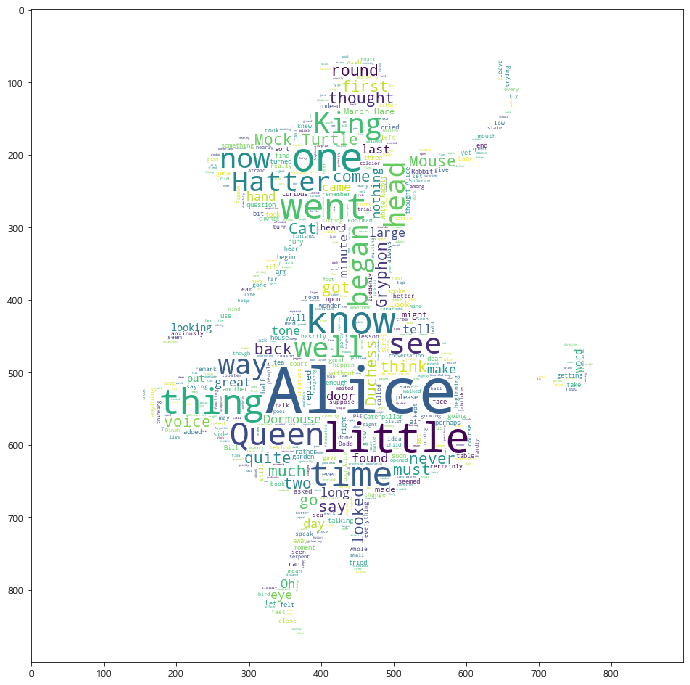

In [89]:
plt.figure(figsize=(12,12))
plt.imshow(wc)   ## imshow : 가지고 있는 이미지로 그래프의 틀을 만들 수 있음
plt.show()

## 3. IMDb의 엔드게임 크롤링 데이터 WordCloud해보기
> ###### 기억날지 모르겟지만.. 저어어어 위에 1-(3)에서 감성분석할때 `sum_review`라는 이름의 변수에다가 모든 리뷰를 더한게 기억나나요? 
> ###### 지금 wordcloud할려고 했던거에요 ㅎㅎ 한번 해봅시다

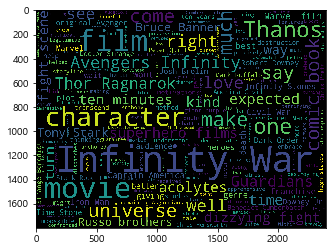

In [86]:
wordcloud = WordCloud(width=2400, height=1800, stopwords=set(STOPWORDS)).generate(sum_review) 
plt.imshow(wordcloud)
plt.show()